# Homework 5
## Due Thursday Apr. 3rd

### Fitting a parabola

Let's quickly create some fake data of a projectile traveling under the influence of gravity.

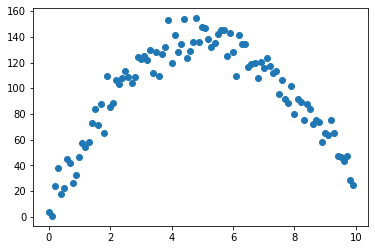

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy.optimize import minimize, curve_fit

t = np.arange(0, 10, 0.1)
y = 10 + 50*t - 9.8*t**2/2
noisy = y + np.random.randn(len(y)) * 10

plt.scatter(t, noisy)

Now we'll conveniently forget that we "knew" acceleration due to gravity for the sake of this exercise. 

We will however remember that objects in motion under the influence of a constant acceleration, in a vacuum, move according to the equation $ x = x_0 + v\cdot t $+$ a\cdot t^2 \over 2$.

We should be able to recover the acceleration due to gravity by finding the three coefficients of a second degree polynomial fit to our fake data (use `noisy`, not `y`).

- a) Write a 2nd degree polynomial function then use $\chi^2$ minimization to find the three best fit coefficients (25 pts)

- b) Plot your best fit results to confirm the goodness of fit (5 pts)

- c) Solve for acceleration due to gravity! (Pretend it's a real problem; I could have given you the data but I figured it was easier to generate it) (5 pts)

Hint: If you're having trouble, try using the Nelder Mead algorithm provided in class; it should converge quickly

Best x_0, v, a: [-3.8484869  51.63004755 -9.79408039]


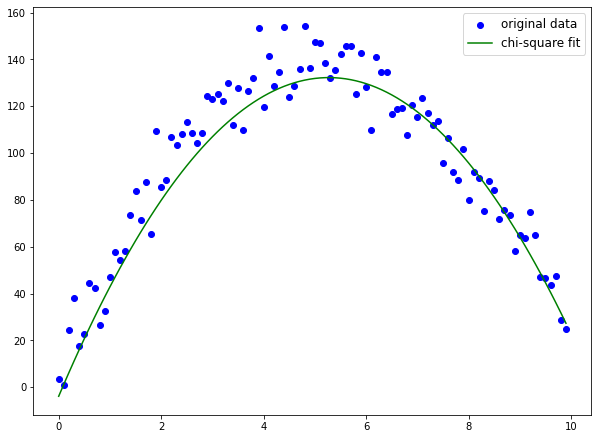

With the plotted data from the model (the blue points) being consistent with my chi square best fit (in 
green), the acceleration due to gravity can be estimated as -9.79 m/s^2, the value from my fit. 


In [2]:
# code

#PART A (chi^2 minimization)

# Nelder Mead algorithm from class
def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5,
                verbose=False, return_steps=False): 
    '''
        f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        x_start (list): initial position
        step (float): look-around radius in initial step
        no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)

        return: tuple (best parameter array, best score)
    '''

    # initial parameters
    # number of dimensions
    dim = len(x_start)

    # prev best score, i.e. score for initial guess
    prev_best = f(x_start)

    # number of iterations with no improvement
    no_improv = 0

    # array of results, updated each loop
    res = [[x_start, prev_best]]

    # create initial simplex
    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    if return_steps: 
        simplexs = []

    # simplex iter
    iters = 0
    while True: 
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]
        if verbose: 
            print(f"{iters}, scores: {[r[1] for r in res]}")
            print(f"{iters}, x: {[r[0] for r in res]}")

        if return_steps: 
            simplexs.append([r[0] for r in res])
        
        # break after max_iter
        if max_iter and iters >= max_iter: 
            if return_steps: 
                return res[0][0], simplexs
            else: 
                return res[0][0]
        iters += 1

        if verbose:
            print('...best so far:', best)

        # break after no_improv_break iterations with no improvement

        if best < prev_best - no_improve_thr: 
            no_improv = 0
            prev_best = best
        else: 
            no_improv += 1

        if no_improv >= no_improv_break: 
            if return_steps: 
                return res[0][0], simplexs
            else: 
                return res[0][0]

        # centroid
        # first create zeroes list of length dim
        x0 = [0.] * dim

        # then loop through all but last result, which is "worst" and will be ignored
        for tup in res[:-1]: 
            this_x = tup[0]
            for i, x_i in enumerate(this_x): 
                # for each dimension of x, add components of res[:-1], i.e. all but the worst
                # but divided by number of components, len(res[:1]), resulting in centroid
                # of all but "worst"
                x0[i] += x_i / (len(res)-1)

        # reflection
        # new point not better than previous best, but better than previous second worst
        # place test point as far from centroid as worst is from centroid
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]: 
            del res[-1]
            if verbose: 
                print("reflected")
            res.append([xr, rscore])
            continue

        # expansion
        # new point now best, keep going in that direction
        # or see if going further in the direction of the worst point is better
        # note gamma = 2 x alpha
        if rscore < res[0][1]: 
            if verbose: 
                print("expanded")
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore: 
                del res[-1]
                res.append([xe, escore])
                continue
            else: 
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        # if we're here, going a distance alpha or gamma didn't find a better option
        # let's going less
        # rho = 1/2 x alpha
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]: 
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        # the loop below mostly handles arbitrary dimensions, but is otherwise needlessly fancy
        # it keeps res[0], the current best, then adds points sigma (0.5 by default) distance 
        # between the best point and the other points of the simplex
        x1 = res[0][0]
        nres = []
        if verbose: 
            print("contract")
        for tup in res: 
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

# Define the function
def quad_func(t, x_0, v, a):      # find best fit coefficients for all of these except t
    return x_0 + v*t + (a*t**2)/2

def chisquare(xdat, ydat, func): 
    chifunc = lambda args: np.sum(np.power((ydat - func(xdat, *args)) / ydat, 2)) / len(xdat)
    return chifunc

chi = chisquare(t, noisy, quad_func)
# Since Nelder Mead is defined, call it here
best = nelder_mead(chi, np.array([0, 0, -9.8], float))
# I used a guess of x_0 = 0 based on the x-values starting near 0 on the original plot of fake data.
# I used v = 0 based on initial velocity of a launched projectile (such as a cannonball) generally being 0
# I used a = -9.8 based on the initial y equation in the first cell; this value resembles Earth's gravitational acceleration

print("Best x_0, v, a:", best)

# # Minimize
# res1 = nelder_mead(quad_func, np.array([-5.]), verbose=True)
# res2 = nelder_mead(quad_func, np.array([-5.]), step=5)

#x_plot = np.arange(-10, 15, 0.1)
#
#plt.plot(x_plot, f(x_plot))
#plt.scatter(res1, f(res1), c="r")
#plt.scatter(res2, f(res2), c="g")

#PART B (2d plot)
# t = np.arange(0, 10, 0.1)
# y_orig = 10 + 50*t - 9.8*t**2/2
# y_chi2 = -3.10131025 + 51.46447971*t - 9.74497755*t**2/2
# noisy_orig = y_orig + np.random.randn(len(y_orig)) * 10
# noisy_chi2 = y_chi2 + np.random.randn(len(y_chi2)) * 10

ymodel = quad_func(t, *best)
plt.figure(figsize=(10,7.5))
plt.scatter(t, noisy, color='blue', label='original data')
plt.plot(t, ymodel, color='green', label='chi-square fit')
plt.legend(fontsize='large')
plt.show()

#PART C (Solve for acceleration due to gravity)
a = best[2]
print(f"With the plotted data from the model (the blue points) being consistent with my chi square best fit (in \n"
      f"green), the acceleration due to gravity can be estimated as {round(a,2)} m/s^2, the value from my fit. ")

### You wrote a gradient descent algorithm, right?

As promised, the other half of this assignment requires your own implementation of a gradient descent algorithm.

Below I have defined a simple function, $2 \sin x + 1$. Your 2-D/N-D gradient descent algorithm should be able to find a reasonable answer with little trouble.

- a) Use your gradient descent algorithm to find the best fit line using chi-square minimization. Feel free to use the existing `line` function in your fitting; you can assume the form and just find coefficients. Make sure the code you wrote for gradient descent is in your turned in assignment. (40 pts)

- b) Plot your best fit results to confirm the goodness of fit (5 pts)

- c) Plot the chi-square surface that along which you descended; feel free to copy-paste the 3-D plotting code from class. (5 pts, +5 bonus** points if you plot the path your algorithm took down the slope)



** I don't think I can enter > 100 in the grade book but if you're already at full credit you probably don't need the bonus right?

Best x: 1.6799690753890268
Best y: 0.8280335306105965
Starred point plotted at: m=1.6799690753890268, b=0.8280335306105965, z=0.02536157612456018


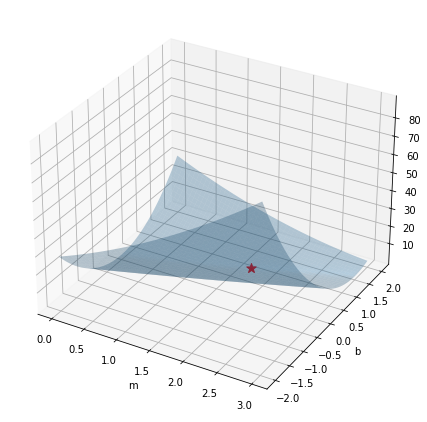

In [3]:
# PART A
def line(x, m, b): 
    return m*np.sin(x) + b

x = np.arange(-2*np.pi, 2*np.pi, np.pi/16)
y = line(x, 2, 1)

def chisquare(xdat, ydat, func): 
    chifunc = lambda args: np.sum(np.power((ydat - func(xdat, *args)) / (ydat), 2)) / len(xdat)
    return chifunc

chi = chisquare(x, y, line)

# Define a step size h for differentiation
h = 0.001

# code
# func = 2*np.sin(x)+1

# Define the gradient (partial derivatives of m and b; chi^2 fitting space)
def df(func, x): 
    return (func(x+h/2)-func(x-h/2))/h

# Modify for partial derivatives
def df2D(func, x, y): 
    df_dx = (func(((x+h/2), y))-func(((x-h/2), y)))/h
    df_dy = (func((x, (y+h/2)))-func(((x, y-h/2))))/h
    return df_dx, df_dy

# Gradient Descent Algorithm
def grad_desc(func, start_point, learning_rate, n_iter): 
    x, y = start_point     # Initial value
    history = []     # To store progress
    
    for n in range(n_iter): 
        grad = df2D(func, x, y)     # Calculate the gradient
        x = x-(learning_rate*grad[0])     # Update to new value of x after each iteration
        y = y-(learning_rate*grad[1])     # Update to new value of y after each iteration
        history.append((x, y))
        
    return x, y, history

# Run the gradient descent by calling it with the three positional arguments
best_x, best_y, history = grad_desc(chi, (1.5,1), learning_rate=0.01, n_iter=50)     # Save optimized x and y values
print(f"Best x: {best_x}")
print(f"Best y: {best_y}")

# Best x is the x-value that returns the lowest value of the original function (f(x), not df(x))

# PARTS B AND C- 3d plot
m_plot = np.linspace(0, 3, 100)     # x-axis
b_plot = np.linspace(-2, 2, 100)     # y-axis
m_plot, b_plot = np.meshgrid(m_plot, b_plot)     # combines 1D arrays to create points
z = np.zeros_like(m_plot)     # creates array of same size as m_plot but with all entries of 0

for i in range(len(b_plot)): 
    for j in range(len(m_plot)): 
        z[i, j] = chi((m_plot[i, j], b_plot[i, j]))     # Recompute z so that it's not always 0 in the shaded region on the plot
        
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 7.5))

surf = ax.plot_surface(m_plot, b_plot, z, alpha=0.3)

ax.scatter(best_x, best_y, chi((best_x, best_y)), marker="*", s=100, color="r")
ax.set_xlabel("m")
ax.set_ylabel("b")
ax.set_zlim(np.min(z), max(np.max(z), chi((best_x, best_y))))

print(f"Starred point plotted at: m={best_x}, b={best_y}, z={chi((best_x, best_y))}")

# Starred point from part b correctly shows on part of shaded region from part c

## You're allowed to use scipy now

The point of this course is to increase your understanding of computational techniques at their fundamental level. Now that we've beat minimization to death, you've earned the right to simply use `scipy.optimize.minimize`.

- a) Exercise that right now by using `minimize` in place of gradient descent or Nelder-Meade to find the best fit of the `line` function above. This may seem like you're substituting a single function name, but note `minimize` returns a "result" not a number/array/tuple. You can access the "answer" with `result.x`; the documentation may also be helpful. (10 points)

- b) In a previouse course you should have seen `scipy.optimize.curve_fit`. Fundamentally, curve_fit is also solving a minimization problem under-the-hood. Can it find the best fit parameters of our `line` function? Try it! Note: `curve_fit` expects inputs in the order `(func, xdat, ydat)`, not the order used in class. In testing, I could not make `curve_fit` converge to the right answer, even if I passed it for the initial guess. Can you? Or have we just demonstrated the need for using lower level functions sometimes?! (5 points)

In [4]:
# code
# PART A
def line(x, m, b): 
    return m*np.sin(x) + b

x = np.arange(-2*np.pi, 2*np.pi, np.pi/16)
y = line(x, 2, 1)

from scipy.optimize import minimize
soln = minimize(chi, np.array([0, 0], float))

soln.x
# [2, 1] is the correct answer for 2sin(x)+1 since 2 is the slope m and 1 is the y-intercept b.

array([1.9999998 , 0.99999989])

In [5]:
#PART B
# Fit the function
popt, pcov = curve_fit(line, x, y, p0=[1, 1])     # Recall that x and y are arrays

# Extract the fitted parameters
m_fit, b_fit = popt     # fit the slope and y-intercept

# Print the results
print(f"Fitted m: {m_fit}, Fitted b: {b_fit}")     # Correct answer of m=2 and b=1

Fitted m: 2.0, Fitted b: 1.0
